In [3]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import pylab as pl

%pylab inline
pl.rcParams['figure.figsize'] = (10,10)
pl.rcParams['font.size'] = 20


from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib


# read in data

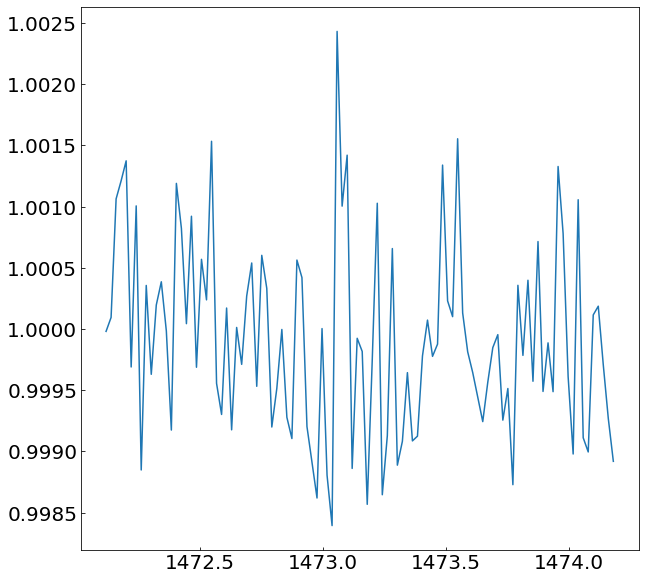

In [5]:
lcvsKep = np.load("data/KeplerSampleWErr.npy")
pl.plot(lcvsKep[10,0], lcvsKep[10,1])



In [6]:
X = lcvsKep

In [7]:
# cant standardize due to spikes...
#X[:,1] = (X[:,1] - np.atleast_2d(X[:,1].mean(axis=1)).T ) /np.atleast_2d(X[:,1].std(axis=1)).T
                    

In [8]:
X.shape

(2500, 3, 100)

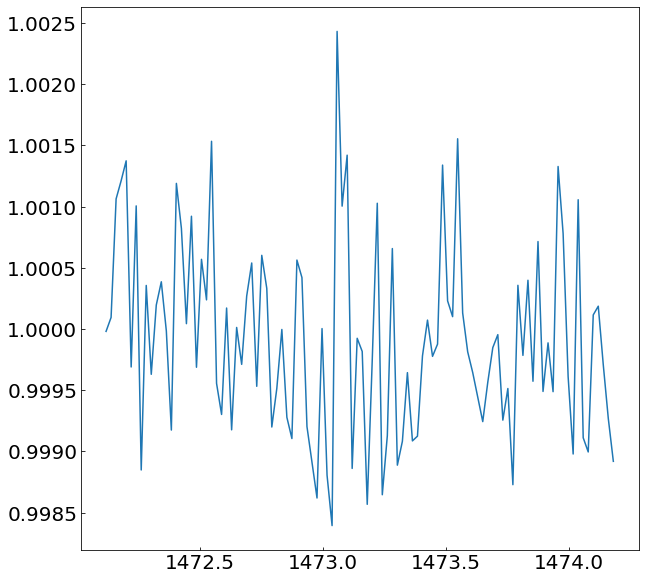

In [11]:
pl.plot(X[10,0], X[10,1])


# remove spikes by low pass filter

In [12]:
X[:,1,:].shape
M = X.copy()
S = X.copy()


In [13]:
X[:,1].shape

(2500, 100)

In [14]:
# replacing spikes: low pass filter
for i in range(len(X)):
    M[i,1] = pd.rolling_mean(X[i,1], window=15, center=True)
    S[i,1] = pd.rolling_std(X[i,1], window=15, center=True)
notnan = (~np.isnan(M[:,1]))[0]
M = M[:,:,notnan]
S = S[:,:,notnan]

Xfixed = X[:,:,notnan].copy()
badpoints = (np.abs(Xfixed[:,1] - M[:,1]) > 3 * S[:,1] )
Xfixed[:,1][badpoints] = M[:,1][badpoints]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


# re-normalize

In [15]:
#normalizing
Xfixed[:,1] = (Xfixed[:,1] / np.atleast_2d(Xfixed[:,1].mean(axis=1)).T ) #/np.atleast_2d(Xfixed[:,1].std(axis=1)).T


# Isolation forest

In [16]:
rng = np.random.RandomState(42)

## parameters: 100 training sample, 10% outliers

In [71]:
clf = IsolationForest(max_samples=100, contamination=0.1, random_state=rng)

In [72]:
clf.fit(Xfixed[:,1,:])#, sample_weight=1.0/(Xfixed[:,2,:])**2)
scores_pred = clf.decision_function(Xfixed[:,1,:])
threshold = stats.scoreatpercentile(scores_pred,
                                100 * 0.1)
y_pred = clf.predict(Xfixed[:,1,:])


In [73]:
sum(y_pred)

2000

printing one very 300 lcvs in decreasing weirdness order


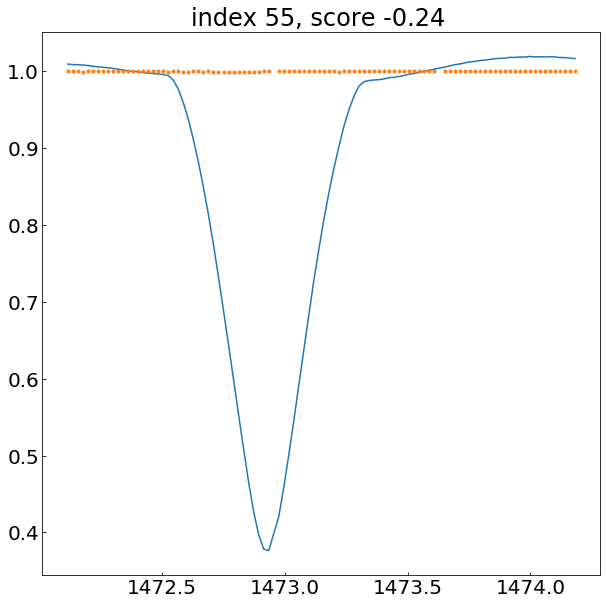

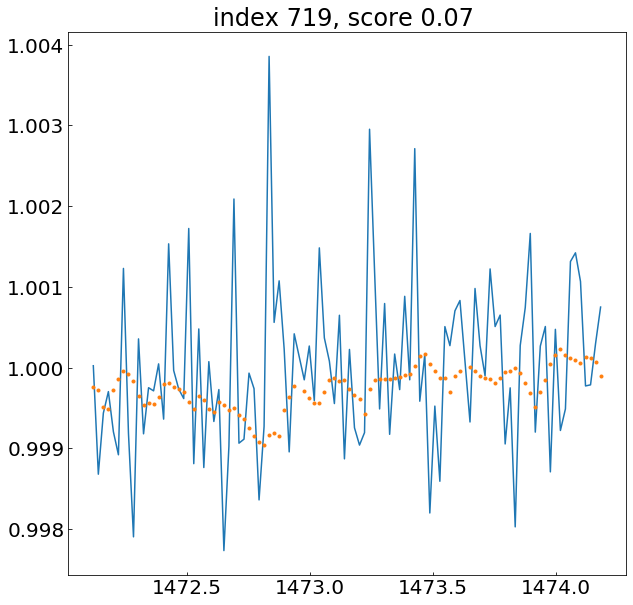

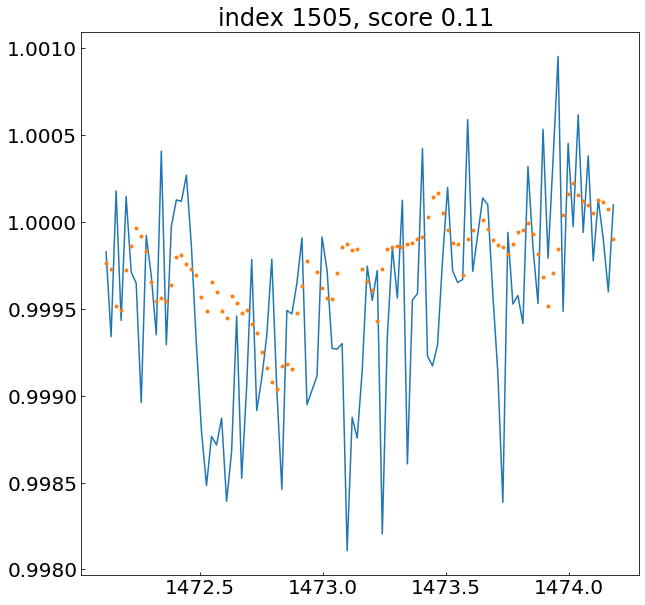

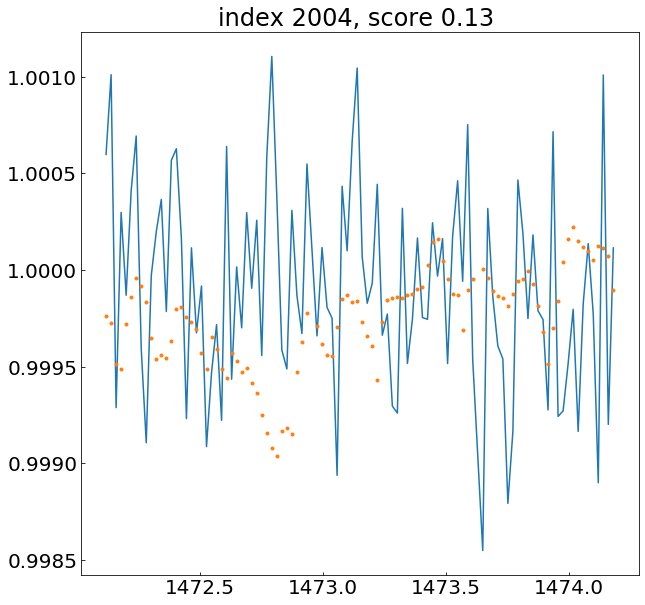

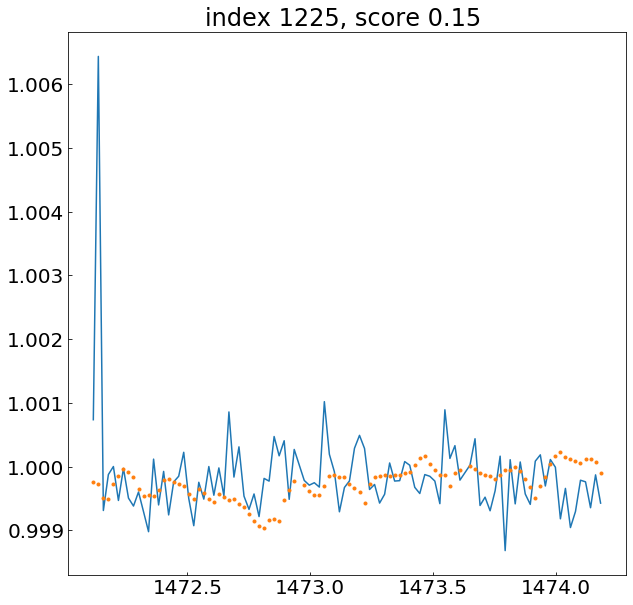

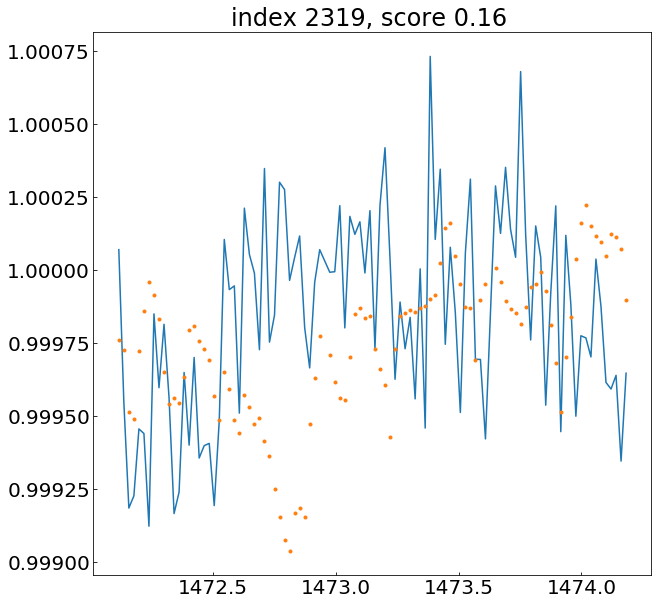

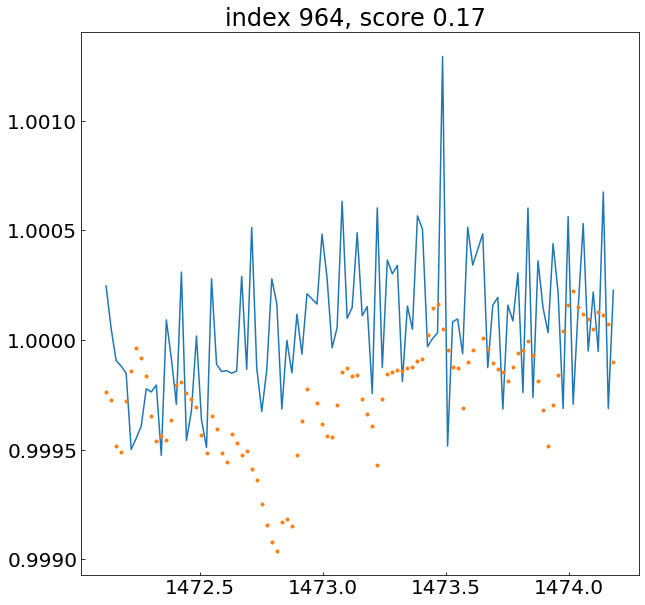

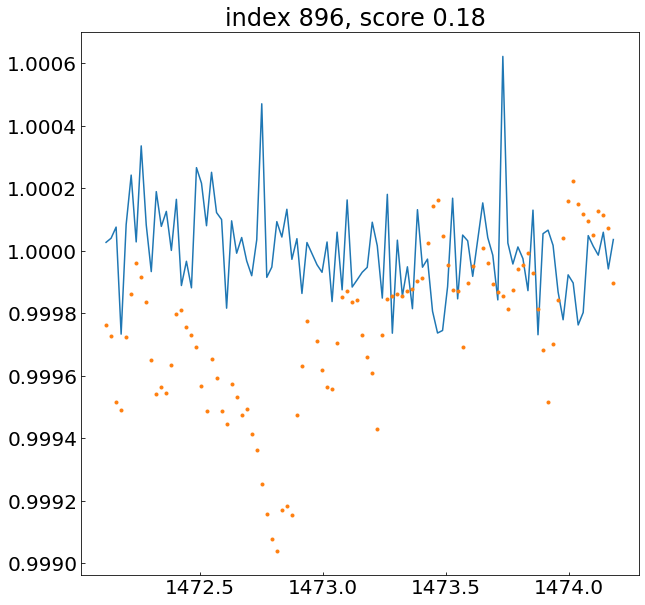

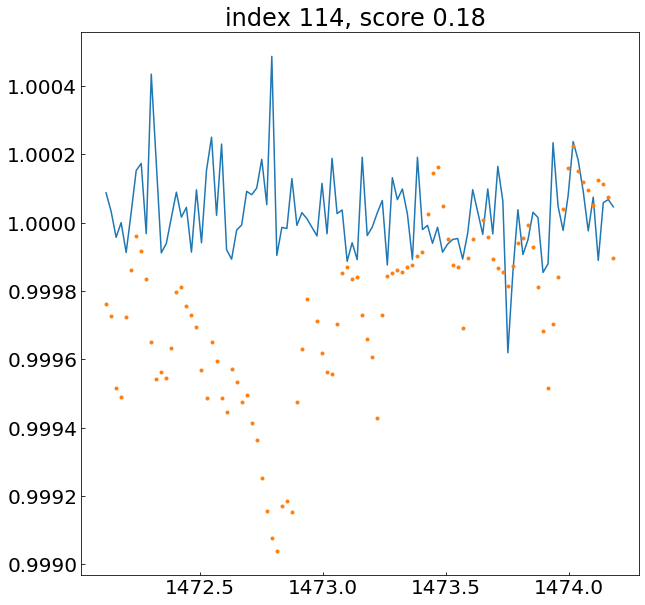

In [74]:
for i in np.argsort(scores_pred)[::300]:
    pl.figure()
    pl.plot(X[i,0], X[i,1], '-')
    pl.plot(X[i,0], X[:,1].mean(0), '.')
    pl.title("index %d, score %.2f "%(i, scores_pred[i]))
    
print ("printing one very 300 lcvs in decreasing weirdness order")

In [75]:
with open("denseKeplerFed.csv","w") as outf:
    print >>outf, "index,score"
    for j,i in  enumerate(np.argsort(scores_pred)[:25]):
        print >> outf, ("{},{:.4f}".format(i,scores_pred[i]))
    


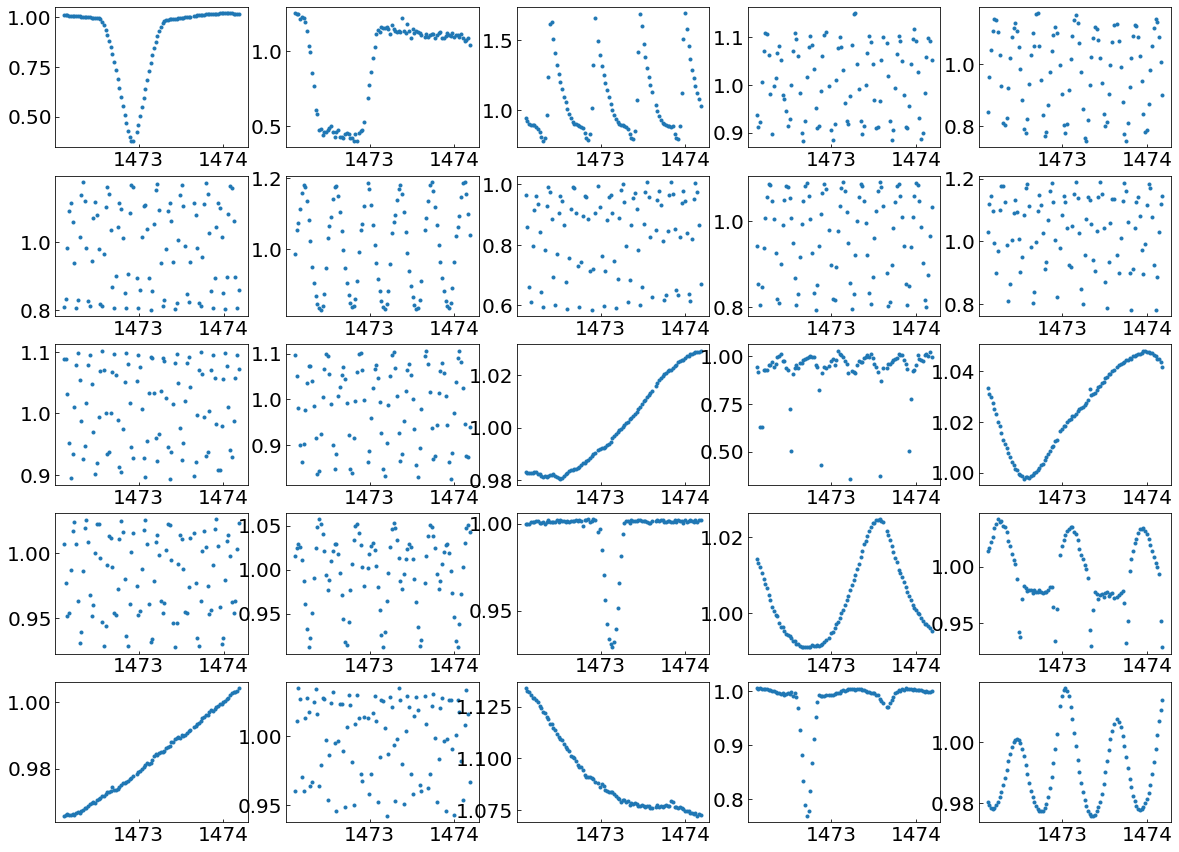

In [76]:
fig = pl.figure(figsize=(20,15))
for j,i in  enumerate(np.argsort(scores_pred)[:25]):
    ax=fig.add_subplot(5,5,j+1)
    ax.plot(X[i,0], X[i,1], '.', label="%.3f"%scores_pred[i])
    



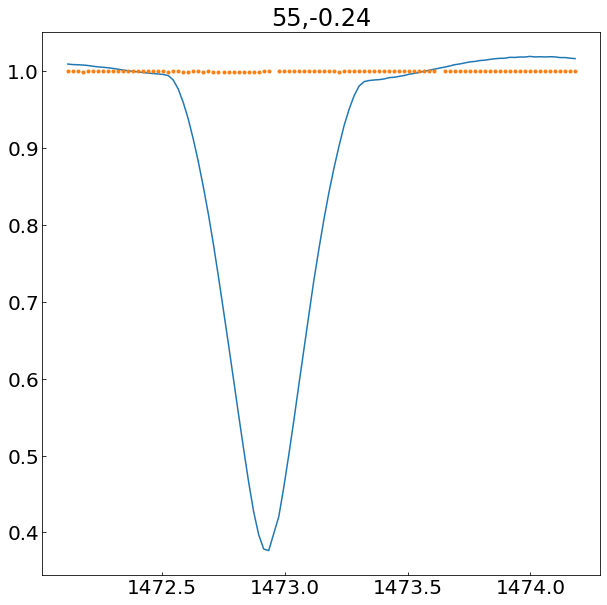

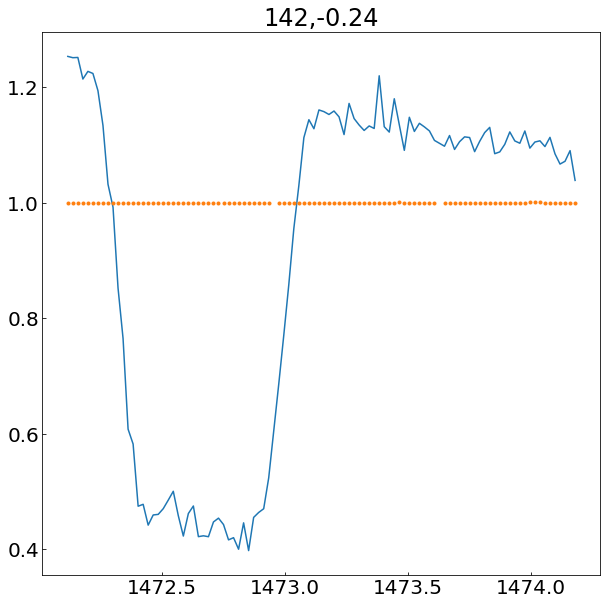

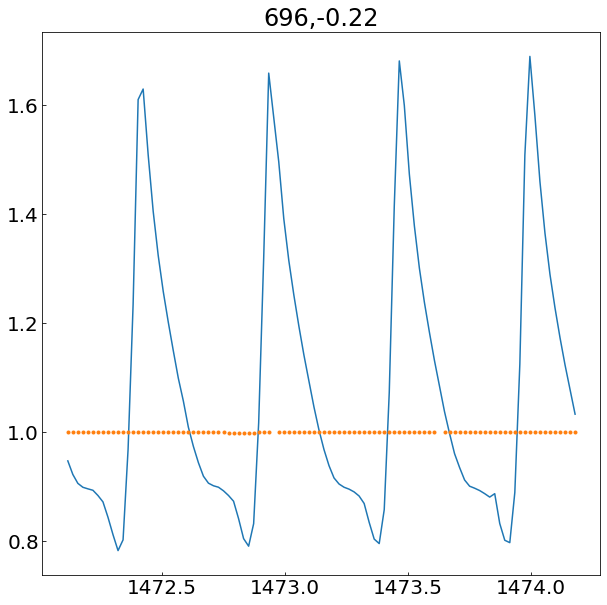

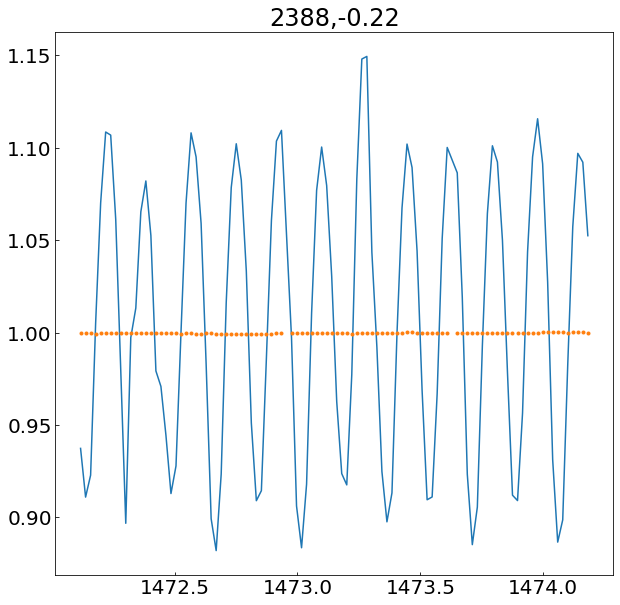

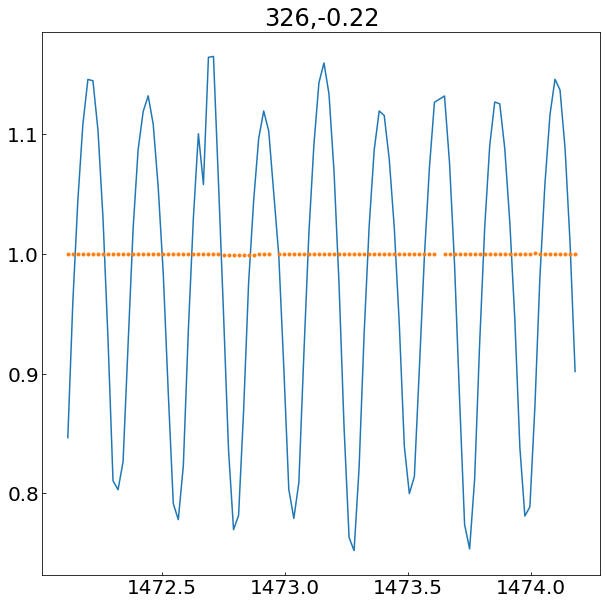

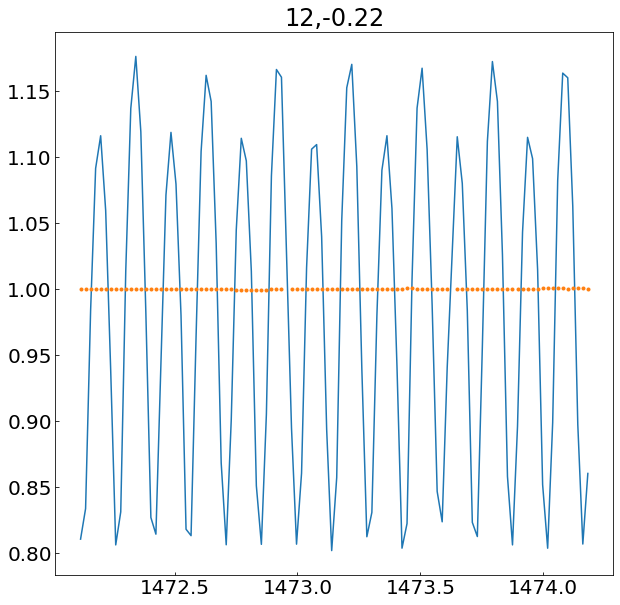

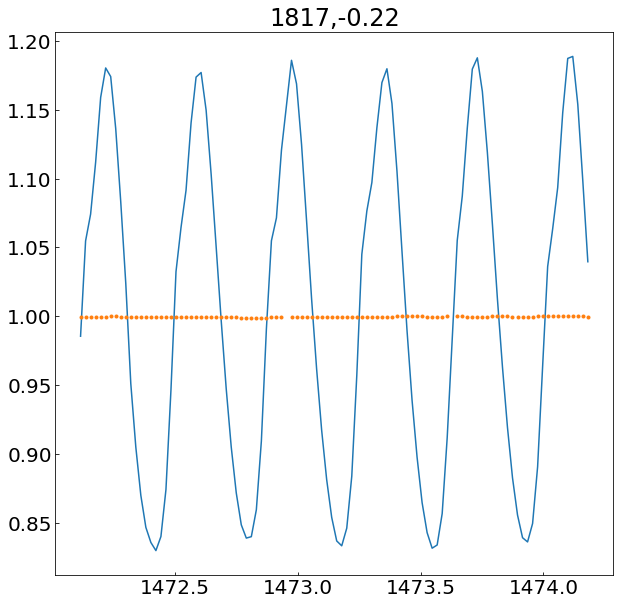

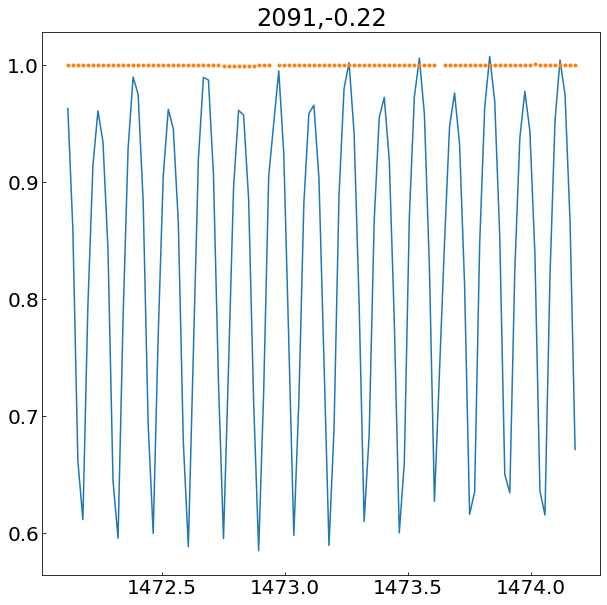

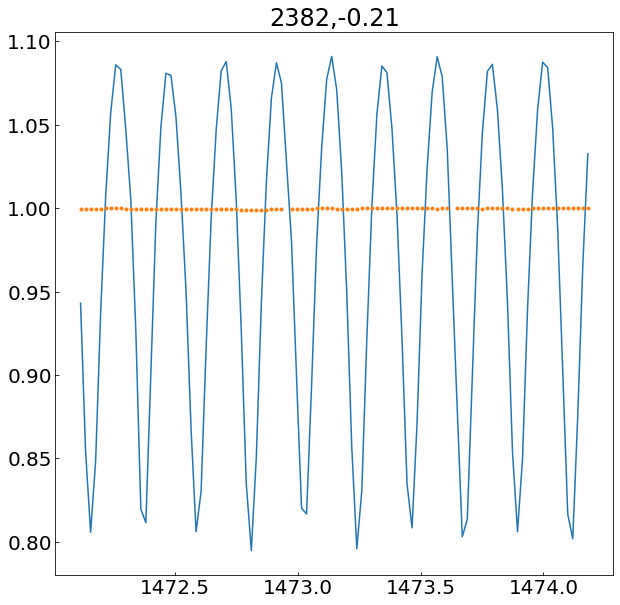

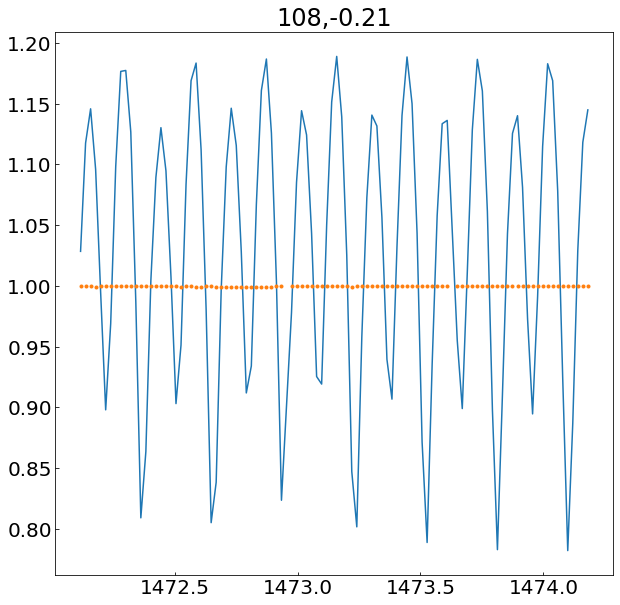

In [77]:
for i in np.argsort(scores_pred)[:10]:
    pl.figure()
    pl.plot(X[i,0], X[i,1], '-')
    pl.plot(X[i,0], X[:,1].mean(0), '.')

    pl.title("%d,%.2f"%(i, scores_pred[i]))
    

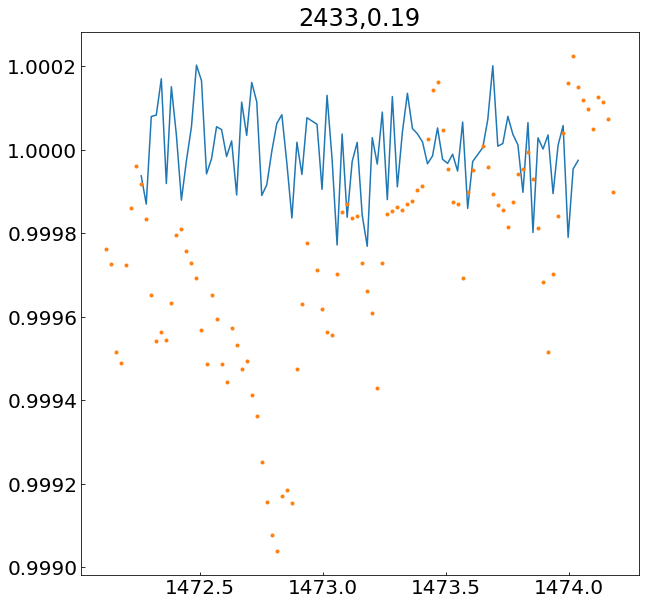

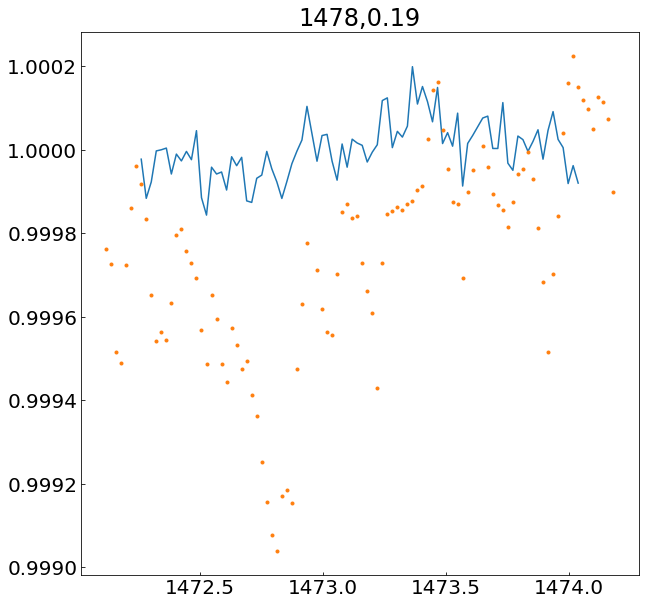

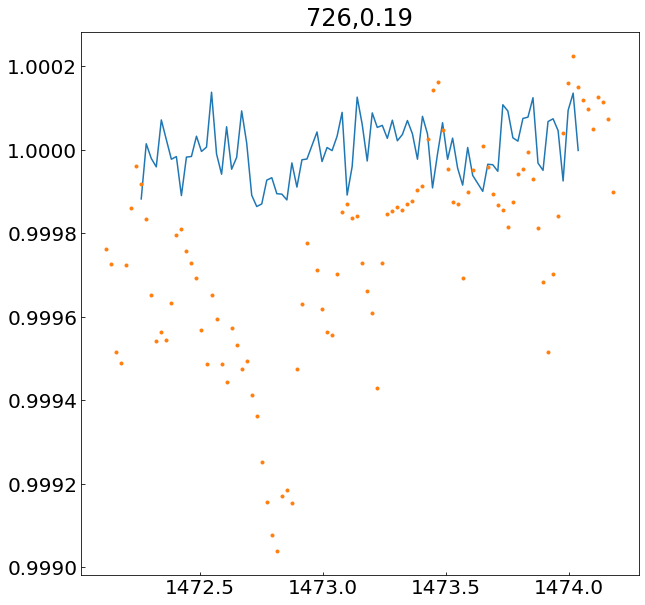

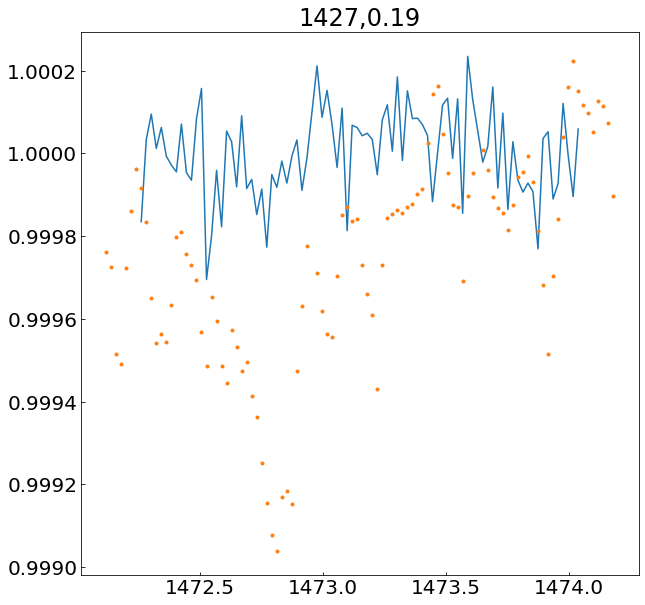

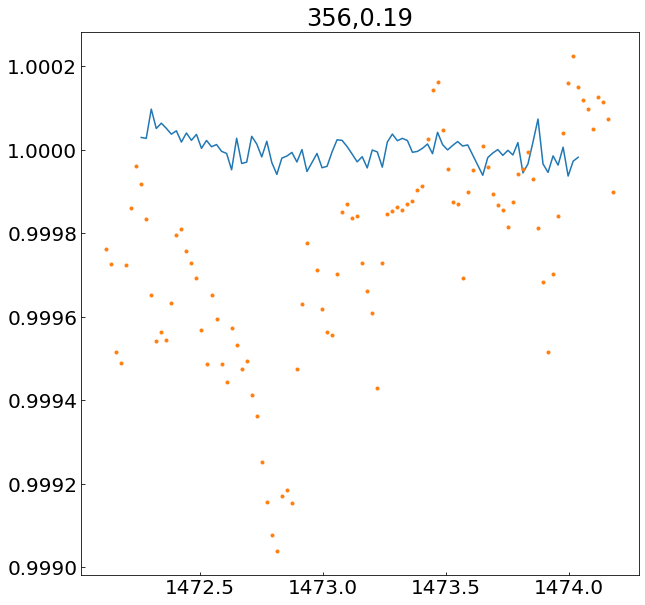

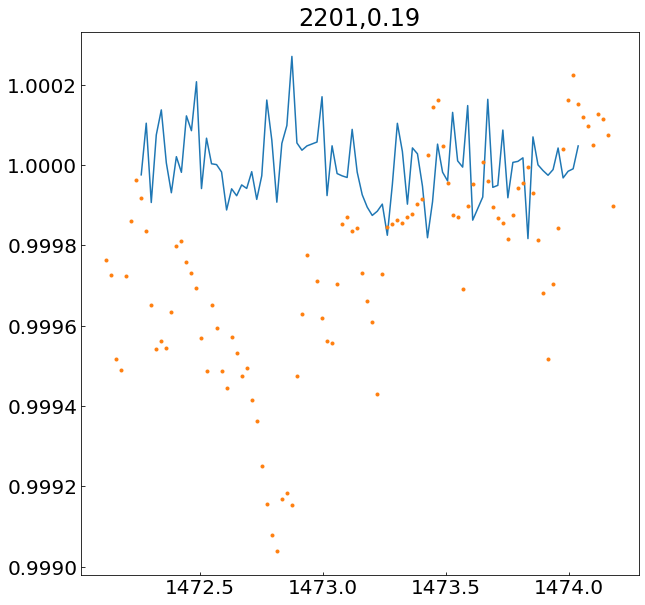

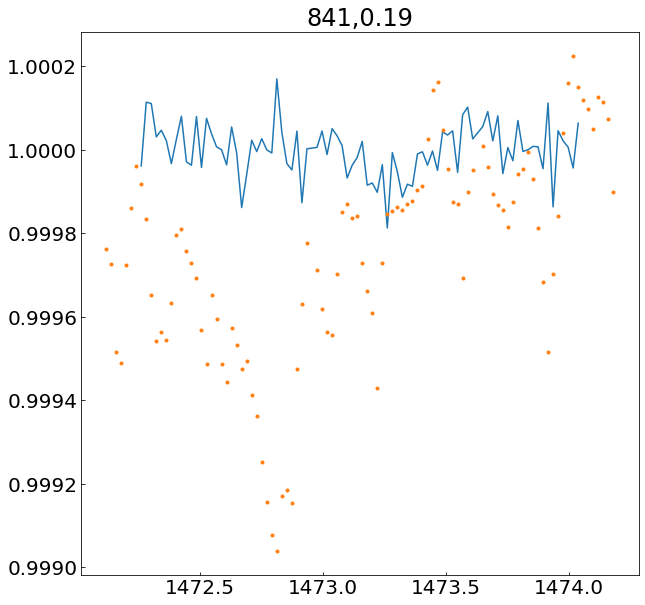

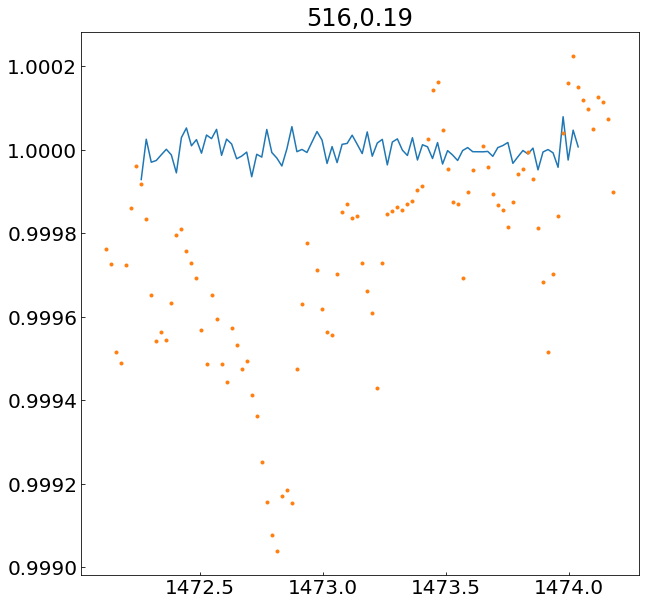

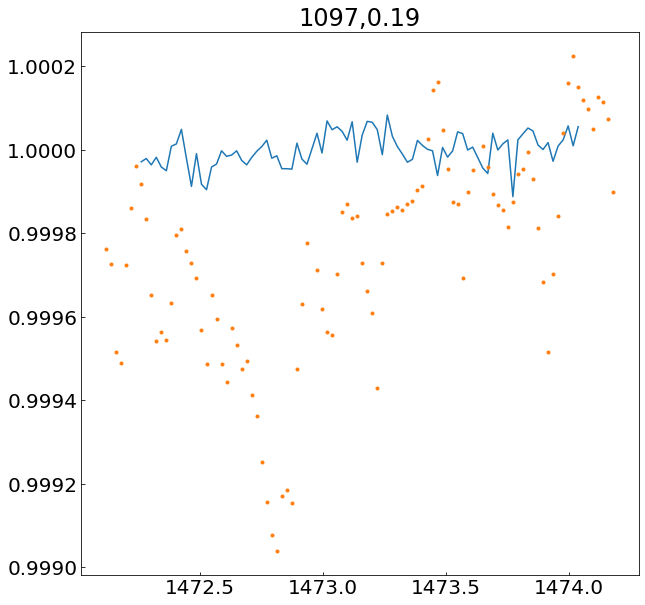

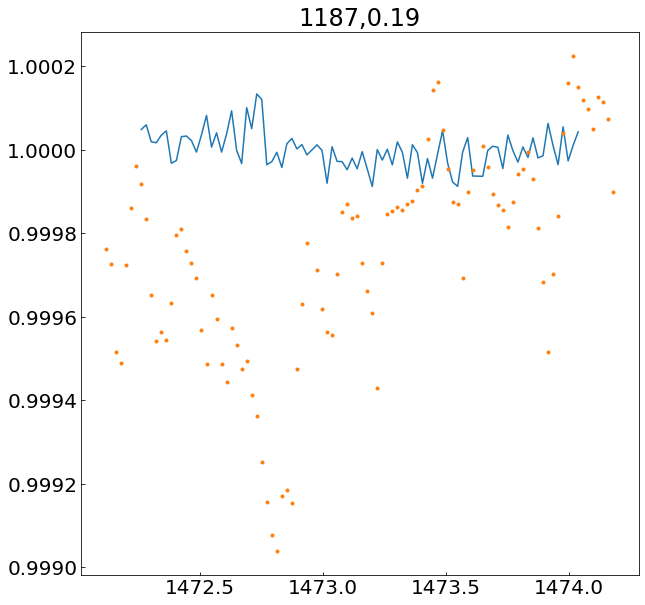

In [78]:
for i in np.argsort(scores_pred)[-10:]:
    pl.figure()
    pl.plot(Xfixed[i,0], Xfixed[i,1], '-')
    pl.plot(X[i,0], X[:,1].mean(0), '.')

    pl.title("%d,%.2f"%(i, scores_pred[i]))

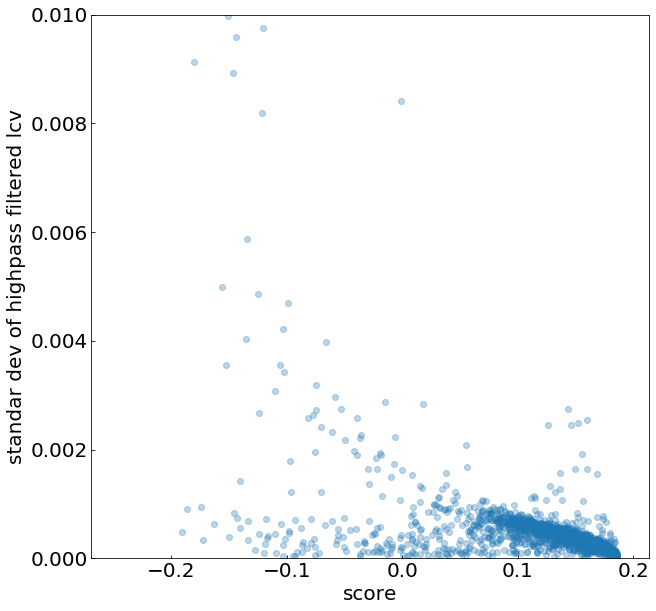

In [79]:
ax = pl.figure().add_subplot(111)
pl.xlabel("score")
pl.ylabel("standar dev of highpass filtered lcv")
pl.scatter(scores_pred, (X[:,:,notnan][:,1] - M[:,1]).std(axis=1), alpha=0.3)
#ax.set_yscale("log")
ax.set_ylim(0,0.01)
pl.savefig("scoreVSsnrFedIsolation.png")

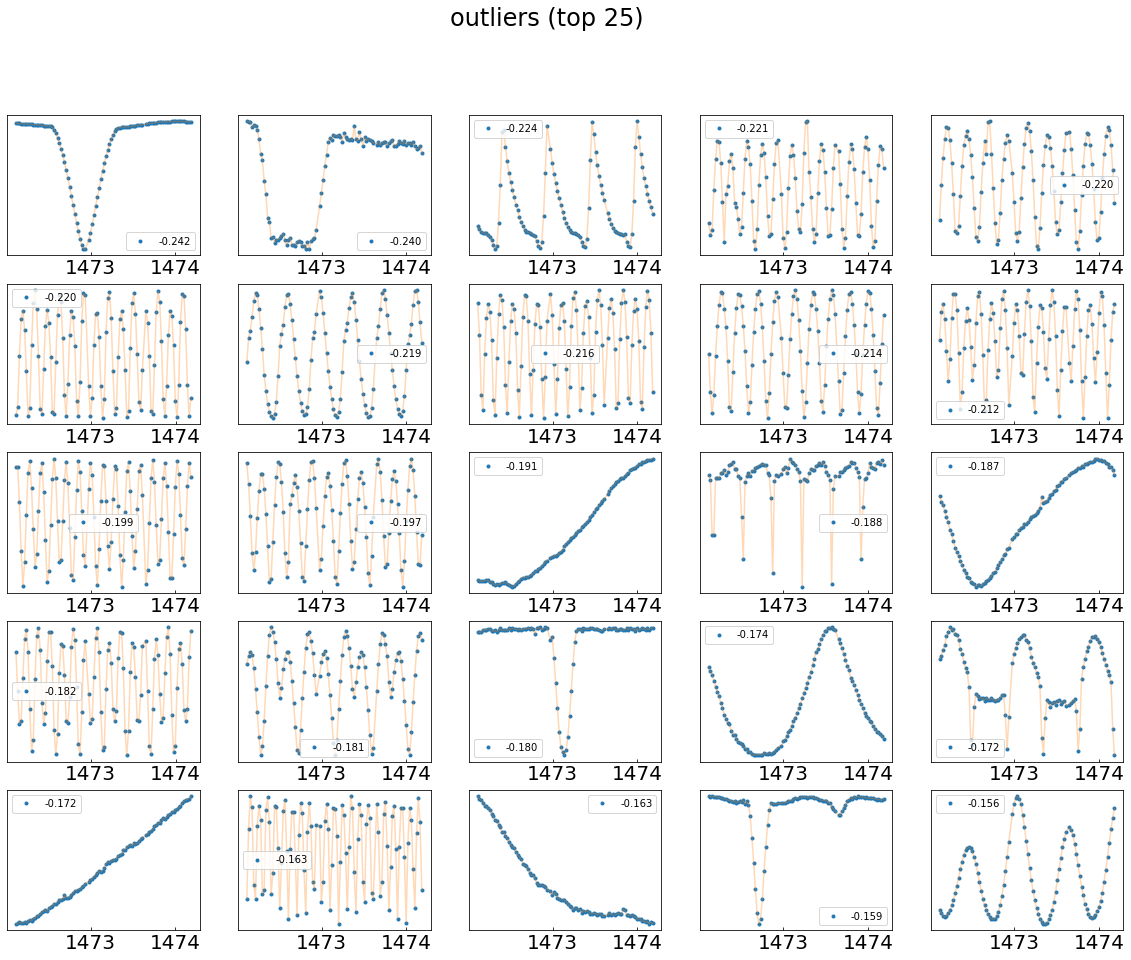

In [80]:
fig = pl.figure(figsize=(20,15))
for j,i in  enumerate(np.argsort(scores_pred)[:25]):
    ax=fig.add_subplot(5,5,j+1)
    ax.plot(X[i,0], X[i,1], '.', label="%.3f"%scores_pred[i])
    ax.plot(X[i,0], X[i,1], '-', alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_yticks([])    
pl.suptitle("outliers (top 25)")
pl.savefig("outliers.png")

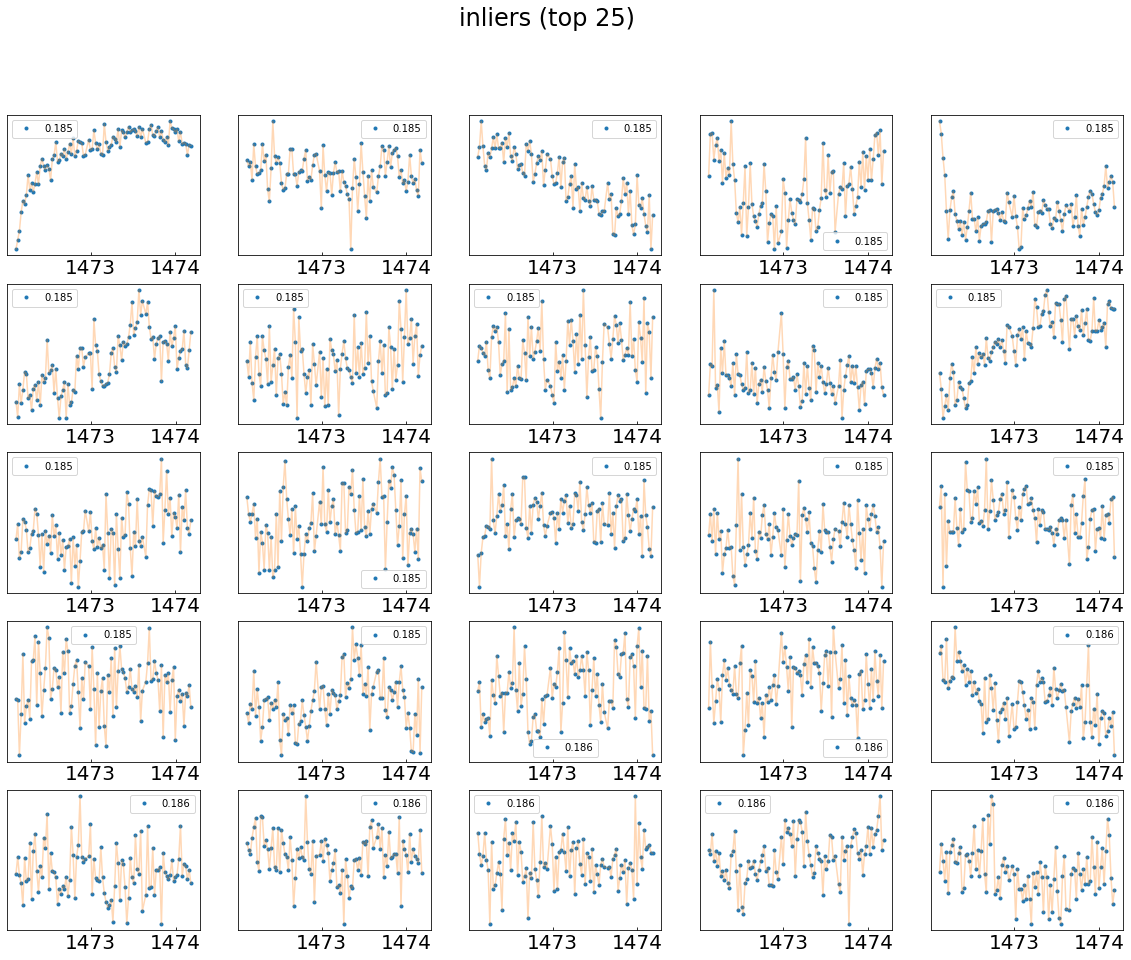

In [81]:
fig = pl.figure(figsize=(20,15))
for j,i in  enumerate(np.argsort(scores_pred)[-25:]):
    ax=fig.add_subplot(5,5,j+1)
    ax.plot(X[i,0], X[i,1], '.', label="%.3f"%scores_pred[i])
    ax.plot(X[i,0], X[i,1], '-', alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_yticks([])
pl.suptitle("inliers (top 25)")
pl.savefig("inliers.png")

In [82]:
df100 = pd.read_csv("denseKeplerFed.csv")
df500 = pd.read_csv("denseKeplerFed500.csv")

In [83]:
df100

,index,score
0,55,-0.2423
1,142,-0.2402
2,696,-0.2241
3,2388,-0.2208
4,326,-0.2202
5,12,-0.2201
6,1817,-0.2195
7,2091,-0.2162
8,2382,-0.2141
9,108,-0.2120


In [84]:
pd.merge(df100, df500, on='index', how="outer")

,index,score_x,score_y
0,55.0,-0.2423,-0.2835
1,142.0,-0.2402,-0.2977
2,696.0,-0.2241,-0.2670
3,2388.0,-0.2208,-0.2619
4,326.0,-0.2202,-0.2623
5,12.0,-0.2201,-0.2854
6,1817.0,-0.2195,-0.2846
7,2091.0,-0.2162,-0.2858
8,2382.0,-0.2141,-0.2590
9,108.0,-0.2120,-0.2627
